<a href="https://colab.research.google.com/github/mariosianturi19/Implementasi-Interpolasi/blob/main/CommonV15_WhisperMedium_Kel6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets librosa soundfile evaluate gradio
!pip install jiwer
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 810.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.0 MB/s eta 0:00:00


In [2]:
!pip install huggingface_hub

In [3]:
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `ucapan_6` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `ucapan_6`

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import librosa
import soundfile as sf
from tqdm.notebook import tqdm
import evaluate
import gradio as gr
from dataclasses import dataclass
from typing import Any, Dict, List, Union

import transformers
print(transformers.__version__)
print("Transformers path:", transformers.__file__)

import os
print(os.listdir())

4.51.3
Transformers path: /usr/local/lib/python3.11/dist-packages/transformers/__init__.py
['.config', 'sample_data']


Whisper adalah model pengenalan ucapan mutakhir yang dikembangkan oleh OpenAI. Model ini mengikuti
arsitektur encoder-decoder Transformer dan telah dilatih sebelumnya pada kumpulan data audio yang
beragam (680.000 jam data berlabel).

Fitur utama Whisper:
- Arsitektur encoder-decoder Transformer
- Performa yang kuat untuk berbagai bahasa dan aksen
- Mampu mengenali ucapan dalam berbagai bahasa (multilingual)
- Efektif bahkan dalam lingkungan yang bising
- Dilatih menggunakan pendekatan terawasi (berbeda dengan Wav2Vec2 yang menggunakan
  pembelajaran mandiri-terawasi)

Model memproses audio dengan:
1. Mengkonversi audio menjadi spektrogram log-mel
2. Mengkodekan spektrogram dengan encoder Transformer
3. Mendekodekan teks dengan decoder Transformer

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan perangkat: {device}")

def load_whisper_model(model_size="medium", multilingual=True):
    if model_size in ["tiny", "base", "small", "medium"] and not multilingual:
        model_name = f"openai/whisper-{model_size}.en"
    else:
        model_name = f"openai/whisper-{model_size}"

    print(f"Memuat {model_name}...")

    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

    return processor, model

processor, model = load_whisper_model(model_size="medium")

Menggunakan perangkat: cuda
Memuat openai/whisper-medium...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [7]:
def load_common_voice_dataset(split="train[:1000]"):
    print(f"Memuat dataset Common Voice untuk bahasa Indonesia, split: {split}")
    dataset = load_dataset(
        "mozilla-foundation/common_voice_15_0",
        "id",
        split=split,
        token=True
    )
    print(f"Dataset dimuat dengan {len(dataset)} sampel")
    return dataset

def load_whisper_model(model_size="medium", multilingual=True):
    if model_size in ["tiny", "base", "small", "medium"] and not multilingual:
        model_name = f"openai/whisper-{model_size}.en"
    else:
        model_name = f"openai/whisper-{model_size}"
    print(f"Memuat model: {model_name} ...")
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
    return processor, model

def prepare_dataset(batch, processor):
    audio = batch["audio"]
    if audio["sampling_rate"] != 16000:
        audio_array = librosa.resample(
            np.asarray(audio["array"]),
            orig_sr=audio["sampling_rate"],
            target_sr=16000
        )
        sampling_rate = 16000
    else:
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]

    batch["input_features"] = processor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_features[0]
    batch["labels"] = processor(text=batch["sentence"]).input_ids
    return batch

try:
    # 1. Load processor dan model
    processor, model = load_whisper_model(model_size="medium")
    # 2. Load dataset (subset 1000 data)
    dataset = load_common_voice_dataset(split="train[:1000]")
    print(f"Berhasil memuat {len(dataset)} sampel untuk bahasa Indonesia")
    # 3. Pre-processing dataset
    processed_dataset = dataset.map(
        lambda x: prepare_dataset(x, processor),
        remove_columns=dataset.column_names,
        num_proc=2
    )
    print(f"Dataset telah diproses dengan {len(processed_dataset)} sampel")
except Exception as e:
    import traceback
    print(f"Error saat menjalankan pipeline: {e}")
    traceback.print_exc()

Memuat model: openai/whisper-medium ...
Memuat dataset Common Voice untuk bahasa Indonesia, split: train[:1000]


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 4968it [00:00, 86984.83it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 3330it [00:00, 103138.62it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 3638it [00:00, 111843.19it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 29292it [00:00, 161423.67it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 2588it [00:00, 85079.43it/s]


Dataset dimuat dengan 1000 sampel
Berhasil memuat 1000 sampel untuk bahasa Indonesia


Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset telah diproses dengan 1000 sampel


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate # Import evaluate here as it's used in compute_metrics

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Pad input features
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Pad labels
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        batch["labels"] = labels
        return batch


# Fungsi untuk evaluasi model
def compute_metrics(pred):
    # Load metrics untuk WER dan CER
    wer_metric = evaluate.load("wer")
    cer_metric = evaluate.load("cer")

    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Ganti -100 dengan pad token id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # Konversi ids ke teks
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Hitung WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    # Hitung CER
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

# Tentukan argumen training
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_speech_recognition",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    num_train_epochs=10,
    warmup_ratio=0.1,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    generation_max_length=225,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    predict_with_generate=True,
    logging_steps=100
)

# Inisialisasi trainer
# Pastikan processed_dataset dan model sudah terdefinisi dari cell sebelumnya
if 'processed_dataset' in locals() and 'model' in locals() and 'processor' in locals():
    # Inisialisasi data collator di dalam blok if
    data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=processed_dataset,
        eval_dataset=processed_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=processor.tokenizer
    )

    print("Trainer berhasil diinisialisasi!")

    # Mulai proses training
    print("Memulai proses training...")
    trainer.train()
    print("Training selesai!")

    # Simpan model yang sudah dilatih
    model_save_path = "./whisper_fine_tuned_indonesia"
    model.save_pretrained(model_save_path)
    processor.save_pretrained(model_save_path)
    print(f"Model berhasil disimpan di {model_save_path}")
else:
    # Added a more specific message about missing variables
    missing_vars = [v for v in ['processed_dataset', 'model', 'processor'] if v not in locals()]
    print(f"Variabel berikut belum terdefinisi: {', '.join(missing_vars)}. Pastikan cell sebelumnya sudah dieksekusi dengan benar.")

Variabel berikut belum terdefinisi: processed_dataset, model, processor. Pastikan cell sebelumnya sudah dieksekusi dengan benar.


In [ ]:
def transcribe_file(audio_file):
    if audio_file is None:
        return "Tidak ada file audio yang diunggah."

    try:
        # Load audio dengan librosa dan secara eksplisit resampling ke 16kHz
        audio_array, original_sr = librosa.load(audio_file, sr=None)  # Load dengan sr asli

        # Tampilkan info untuk debugging
        print(f"Audio asli: sampling rate={original_sr}, bentuk={audio_array.shape}")

        # Resampling ke 16kHz jika bukan 16kHz
        if original_sr != 16000:
            print(f"Melakukan resampling dari {original_sr}Hz ke 16000Hz")
            audio_array = librosa.resample(audio_array, orig_sr=original_sr, target_sr=16000)

        # Pastikan audio mono
        if len(audio_array.shape) > 1 and audio_array.shape[1] > 1:
            audio_array = audio_array[:, 0]

        # Proses dengan processor whisper, secara eksplisit tentukan sampling rate 16kHz
        input_features = processor(
            audio_array,
            sampling_rate=16000,  # Tentukan sampling rate dengan jelas
            return_tensors="pt"
        ).input_features.to(device)

        # Buat transkripsi
        forced_decoder_ids = processor.get_decoder_prompt_ids(language="id", task="transcribe")
        with torch.no_grad():
            generated_ids = model.generate(
                input_features=input_features,
                forced_decoder_ids=forced_decoder_ids
            )

        # Konversi ke teks
        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return transcription
    except Exception as e:
        import traceback
        return f"Error: {str(e)}\n\n{traceback.format_exc()}"

In [ ]:
import gradio as gr
import librosa
import numpy as np
import torch
import os
import time
from datetime import datetime
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Definisikan model dan processor dalam scope global
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {device}")

# Load model dan processor
def load_whisper_model(model_size="small", model_path=None):
    if model_path and os.path.exists(model_path):
        print(f"Memuat model dari {model_path}")
        processor = WhisperProcessor.from_pretrained(model_path)
        model = WhisperForConditionalGeneration.from_pretrained(model_path).to(device)
    else:
        print(f"Memuat model Whisper {model_size} dari Hugging Face")
        processor = WhisperProcessor.from_pretrained(f"openai/whisper-{model_size}")
        model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{model_size}").to(device)

    return processor, model

# Memuat model - ubah ke path model fine-tuned Anda jika tersedia
model_path = "./whisper_fine_tuned_indonesia" if os.path.exists("./whisper_fine_tuned_indonesia") else None
processor, model = load_whisper_model(model_size="small", model_path=model_path)

def create_transcription_ui():
    # CSS untuk tampilan dark mode
    custom_css = """
    .gradio-container {
        background: linear-gradient(to right, #1a1a2e, #16213e);
        color: #e2e8f0;
    }

    .main-header {
        color: #e2e8f0;
        text-align: center;
        font-weight: bold;
        margin-bottom: 1rem;
        padding: 1rem;
        border-bottom: 2px solid #4361ee;
        background: rgba(26, 32, 44, 0.8);
        border-radius: 8px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.3);
    }

    .result-container {
        border-radius: 8px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.3);
        padding: 1rem;
        background: #1e293b;
        transition: all 0.3s ease;
    }

    .result-container:hover {
        box-shadow: 0 8px 15px rgba(0, 0, 0, 0.4);
    }

    .footer {
        text-align: center;
        margin-top: 2rem;
        font-size: 0.8rem;
        color: #a0aec0;
    }

    .info-box {
        background: rgba(66, 153, 225, 0.1);
        border-left: 4px solid #4361ee;
        padding: 1rem;
        margin: 1rem 0;
        border-radius: 4px;
        color: #e2e8f0;
    }

    /* Dark mode for Gradio components */
    .dark-theme .gr-button-primary {
        background-color: #4361ee !important;
    }

    .dark-theme .gr-input, .dark-theme .gr-textarea, .dark-theme .gr-checkbox {
        background-color: #2d3748 !important;
        color: #e2e8f0 !important;
        border-color: #4a5568 !important;
    }

    .dark-theme .gr-panel {
        background-color: #1e293b !important;
        color: #e2e8f0 !important;
    }

    .dark-theme .gr-accordion {
        background-color: #1e293b !important;
        color: #e2e8f0 !important;
    }

    .dark-theme .gr-form {
        background-color: #1e293b !important;
        color: #e2e8f0 !important;
    }

    .dark-theme label {
        color: #e2e8f0 !important;
    }
    """

    # Fungsi untuk transkripsi
    def transcribe(audio_path, show_details=False):
        # Referensi ke variabel global
        global processor, model, device

        if audio_path is None:
            return "Tidak ada audio yang diberikan. Silakan unggah atau rekam audio.", None, "⚠️ Tidak ada audio", None

        start_time = time.time()
        audio_info = {}

        try:
            if isinstance(audio_path, str):
                # Load audio dengan sampling rate 16000Hz
                audio_array, sample_rate = librosa.load(audio_path, sr=16000)
                audio_info = {
                    "File": os.path.basename(audio_path),
                    "Duration": f"{len(audio_array)/sample_rate:.2f} detik",
                    "Sample Rate": f"{sample_rate} Hz",
                    "Shape": audio_array.shape
                }
            elif isinstance(audio_path, np.ndarray):
                audio_array = audio_path
                sample_rate = 16000
                audio_info = {
                    "Type": "NumPy Array",
                    "Shape": audio_array.shape,
                    "Sample Rate": f"{sample_rate} Hz",
                }
            elif isinstance(audio_path, tuple):
                sample_rate, audio_array = audio_path
                # Resampling jika perlu
                if sample_rate != 16000:
                    audio_array = librosa.resample(
                        np.asarray(audio_array),
                        orig_sr=sample_rate,
                        target_sr=16000
                    )
                audio_info = {
                    "Original Sample Rate": f"{sample_rate} Hz",
                    "Resampled": "Yes" if sample_rate != 16000 else "No",
                    "Shape": audio_array.shape
                }
            else:
                return f"Format audio tidak dikenali: {type(audio_path)}", None, "❌ Error", None

            # Pastikan audio mono
            if len(audio_array.shape) > 1 and audio_array.shape[1] > 1:
                audio_array = audio_array[:, 0]
                audio_info["Converted to Mono"] = "Yes"

            # Proses dengan processor Whisper
            input_features = processor(
                audio_array,
                sampling_rate=16000,  # Selalu 16kHz
                return_tensors="pt"
            ).input_features.to(device)

            # Buat transkripsi
            forced_decoder_ids = processor.get_decoder_prompt_ids(language="id", task="transcribe")
            with torch.no_grad():
                generated_ids = model.generate(
                    input_features=input_features,
                    forced_decoder_ids=forced_decoder_ids
                )

            # Konversi ke teks
            transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            # Hitung waktu
            elapsed_time = time.time() - start_time

            # Buat waveform visualization dengan tema gelap
            import matplotlib.pyplot as plt
            plt.style.use('dark_background')
            fig, ax = plt.subplots(1, 1, figsize=(10, 2), facecolor='#1e293b')
            ax.plot(audio_array, linewidth=1, color='#4361ee')
            ax.set_axis_off()
            plt.tight_layout()

            # Info tambahan untuk ditampilkan
            process_info = {
                "Model": f"Whisper {model.config.model_type}",
                "Device": device,
                "Processing Time": f"{elapsed_time:.2f} detik"
            }

            # Gabungkan info untuk ditampilkan
            if show_details:
                audio_info_str = "\n".join([f"**{k}**: {v}" for k, v in audio_info.items()])
                process_info_str = "\n".join([f"**{k}**: {v}" for k, v in process_info.items()])
                details = f"### Info Audio\n{audio_info_str}\n\n### Info Proses\n{process_info_str}"
            else:
                details = ""

            return transcription, fig, "✅ Berhasil", details

        except Exception as e:
            import traceback
            tb = traceback.format_exc()
            print(f"Error detail: {tb}")
            return f"Error saat transkripsi: {str(e)}", None, "❌ Error", tb

    # Fungsi untuk menyimpan riwayat transkripsi
    def add_to_history(audio_path, transcription):
        if transcription is None or transcription.startswith("Error") or transcription == "":
            return "Tidak ada transkripsi untuk disimpan"

        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        if isinstance(audio_path, str):
            audio_name = os.path.basename(audio_path)
        else:
            audio_name = f"Recording_{timestamp}"

        # Simpan ke file history
        history_file = "transcription_history.txt"
        try:
            with open(history_file, "a", encoding="utf-8") as f:
                f.write(f"[{timestamp}] {audio_name}: {transcription}\n")
        except:
            pass

        # Baca 10 entri terakhir
        history_entries = []
        try:
            if os.path.exists(history_file):
                with open(history_file, "r", encoding="utf-8") as f:
                    lines = f.readlines()
                    history_entries = lines[-10:]  # Ambil 10 terakhir
        except:
            history_entries = [f"[{timestamp}] {audio_name}: {transcription}"]

        # Format history untuk ditampilkan
        history_md = "### Riwayat Transkripsi\n\n"
        for i, entry in enumerate(reversed(history_entries)):
            history_md += f"{i+1}. {entry}"

        return history_md

    # Header dan deskripsi
    header = """
    <div class="main-header">
        <h1>🎙️ Pengenalan Ucapan Kelompok 6</h1>
        <p>Model Whisper untuk Pengenalan Ucapan Bahasa Indonesia</p>
    </div>
    """

    # Footer
    footer = """
    <div class="footer">
        <p>Tugas Kecerdasan Buatan - 2025</p>
        <p>Model: Whisper | Dataset: Mozilla Common Voice Indonesia</p>
    </div>
    """

    # Info box
    info_box = """
    <div class="info-box">
        <p><strong>Cara Penggunaan:</strong></p>
        <ol>
            <li>Unggah file audio atau rekam audio langsung</li>
            <li>Klik tombol "Transkripsi" untuk memproses audio</li>
            <li>Hasil transkripsi akan muncul di bawah</li>
        </ol>
        <p><small>Durasi audio optimal: 5-30 detik. Format yang didukung: MP3, WAV, OGG</small></p>
    </div>
    """

    # Buat UI dengan Gradio Blocks untuk tata letak yang lebih fleksibel
    with gr.Blocks(css=custom_css, theme=gr.themes.Soft(primary_hue="blue", neutral_hue="slate")) as demo:
        # Tambahkan class untuk dark theme
        demo.elem_classes = ["dark-theme"]

        gr.HTML(header)

        with gr.Row():
            with gr.Column(scale=2):
                gr.HTML(info_box)
                audio_input = gr.Audio(
                    sources=["upload", "microphone"],
                    type="filepath",
                    label="Audio Input"
                )
                show_details = gr.Checkbox(
                    label="Tampilkan Detail Teknis",
                    value=False
                )

                with gr.Row():
                    transcribe_btn = gr.Button("🎯 Transkripsi", variant="primary")
                    clear_btn = gr.Button("🗑️ Bersihkan")

            with gr.Column(scale=3, elem_classes="result-container"):
                status = gr.Markdown("⏳ Siap memproses audio")
                result = gr.Textbox(
                    label="Hasil Transkripsi",
                    placeholder="Hasil transkripsi akan muncul di sini...",
                    lines=5
                )
                waveform = gr.Plot(label="Waveform")
                details = gr.Markdown(visible=False)

        with gr.Accordion("Riwayat Transkripsi", open=False):
            history_display = gr.Markdown()

        gr.HTML(footer)

        # Set up event handlers
        transcribe_btn.click(
            fn=transcribe,
            inputs=[audio_input, show_details],
            outputs=[result, waveform, status, details]
        ).then(
            fn=add_to_history,
            inputs=[audio_input, result],
            outputs=[history_display]
        )

        # Show/hide details based on checkbox
        show_details.change(
            fn=lambda show, detail: gr.update(visible=show),
            inputs=[show_details, details],
            outputs=[details]
        )

        # Clear button
        clear_btn.click(
            fn=lambda: [None, None, "⏳ Siap memproses audio", None],
            inputs=[],
            outputs=[result, waveform, status, details]
        )

    return demo

# Luncurkan UI
try:
    # Pastikan matplotlib tersedia dengan tema gelap
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')

    # Launch Gradio UI
    demo = create_transcription_ui()
    demo.launch(share=True)
except Exception as e:
    print(f"Error saat meluncurkan UI: {str(e)}")
    import traceback
    traceback.print_exc()

Menggunakan device: cuda
Memuat model Whisper small dari Hugging Face


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0011e787df46a1af3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Grafik training metrics disimpan ke './training_metrics.png'


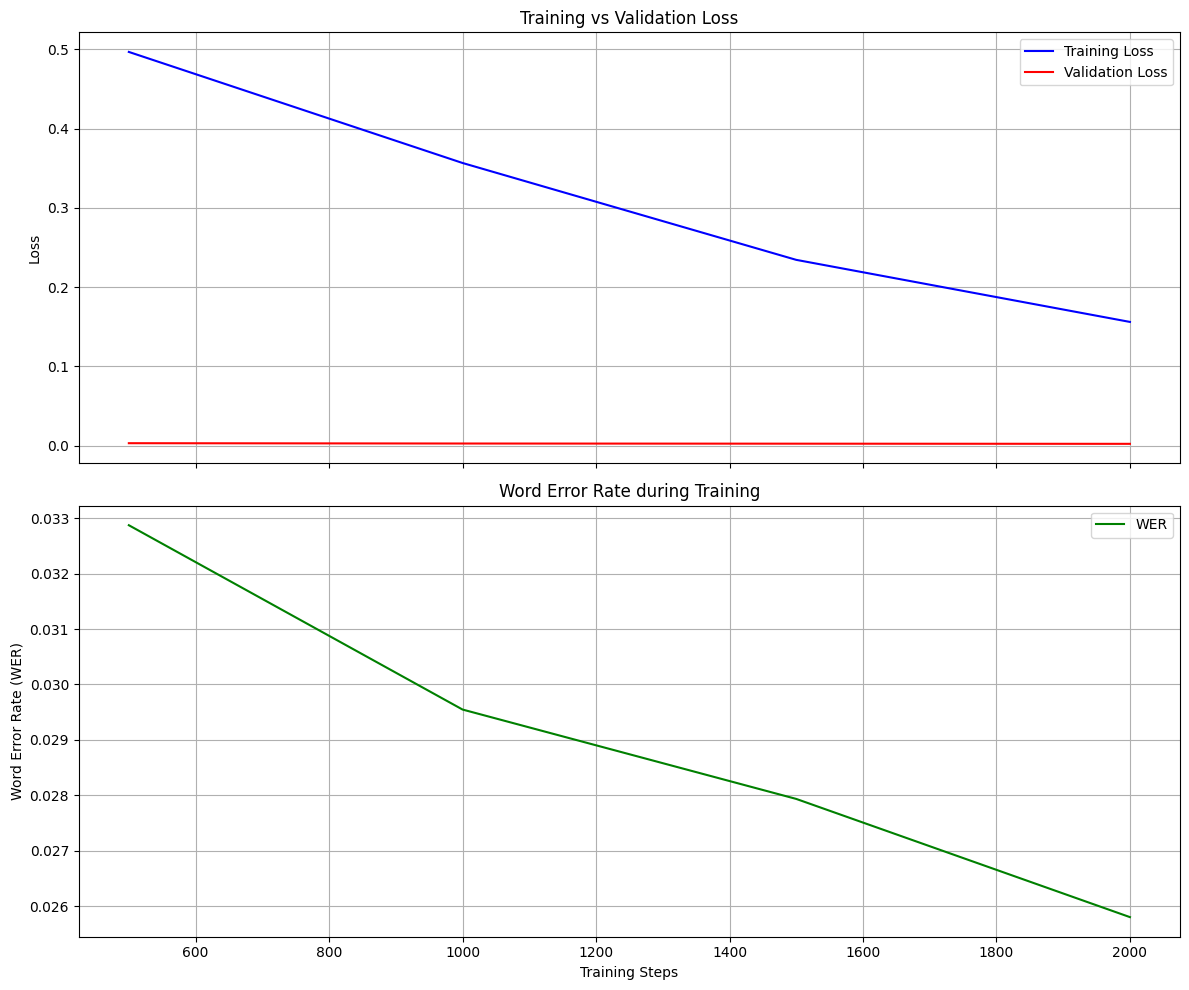

In [ ]:
import json

def plot_training_metrics(log_dir="./whisper_speech_recognition", output_path="./training_metrics.png"):
    """
    Membuat grafik training vs validation loss dan error rate (WER)

    Args:
        log_dir: Direktori tempat log/history pelatihan disimpan
        output_path: Path untuk menyimpan grafik hasil
    """
    # Cek apakah direktori ada
    if not os.path.exists(log_dir):
        print(f"Direktori log pelatihan '{log_dir}' tidak ditemukan.")
        return

    # Cari file log pelatihan (trainer_state.json)
    state_file = os.path.join(log_dir, "trainer_state.json")
    if not os.path.exists(state_file):
        # Coba cari sub-direktori (biasanya checkpoint)
        subdirs = [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
        for subdir in subdirs:
            potential_file = os.path.join(log_dir, subdir, "trainer_state.json")
            if os.path.exists(potential_file):
                state_file = potential_file
                break

    if not os.path.exists(state_file):
        print(f"File trainer_state.json tidak ditemukan di '{log_dir}' atau sub-direktorinya.")
        return

    # Muat log pelatihan
    with open(state_file, 'r') as f:
        training_data = json.load(f)

    # Ambil data metrik
    log_history = training_data['log_history']

    # Siapkan data untuk diplot
    training_steps = []
    training_loss = []
    eval_steps = []
    eval_loss = []
    eval_wer = []

    for entry in log_history:
        # Training logs
        if 'loss' in entry and 'step' in entry and 'eval_loss' not in entry:
            training_steps.append(entry['step'])
            training_loss.append(entry['loss'])

        # Evaluation logs
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_loss.append(entry['eval_loss'])
            if 'eval_wer' in entry:
                eval_wer.append(entry['eval_wer'])

    # Buat DataFrame untuk memudahkan visualisasi
    training_df = pd.DataFrame({
        'step': training_steps,
        'training_loss': training_loss
    })

    eval_df = pd.DataFrame({
        'step': eval_steps,
        'eval_loss': eval_loss
    })

    if eval_wer:
        eval_df['eval_wer'] = eval_wer

    # Plot metrik dengan 2 subplot (Loss dan WER)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # 1. Plot Training vs Validation Loss
    ax1.plot(training_df['step'], training_df['training_loss'], 'b-', label='Training Loss')
    ax1.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # 2. Plot WER (jika ada)
    if 'eval_wer' in eval_df.columns:
        ax2.plot(eval_df['step'], eval_df['eval_wer'], 'g-', label='WER')
        ax2.set_ylabel('Word Error Rate (WER)')
        ax2.set_title('Word Error Rate during Training')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'Data WER tidak tersedia',
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes)

    # Pengaturan umum
    ax2.set_xlabel('Training Steps')
    plt.tight_layout()

    # Simpan grafik
    plt.savefig(output_path)
    print(f"Grafik training metrics disimpan ke '{output_path}'")

    # Tampilkan grafik
    plt.show()

    # Tampilkan juga statistik terakhir
    print("\nStatistik Terakhir:")
    if len(training_loss) > 0:
        print(f"Final Training Loss: {training_loss[-1]:.6f}")
    if len(eval_loss) > 0:
        print(f"Final Validation Loss: {eval_loss[-1]:.6f}")
    if len(eval_wer) > 0:
        print(f"Final WER: {eval_wer[-1]:.6f}")

    return {
        'training_df': training_df,
        'eval_df': eval_df
    }

# Fungsi alternatif jika log tidak dalam format trainer_state.json
def plot_training_metrics_from_csv(csv_path, output_path="./training_metrics.png"):
    """
    Membuat grafik training vs validation loss dan error rate dari file CSV

    Args:
        csv_path: Path ke file CSV dengan kolom step, train_loss, eval_loss, wer
        output_path: Path untuk menyimpan grafik hasil
    """
    # Muat data dari CSV
    if not os.path.exists(csv_path):
        print(f"File CSV '{csv_path}' tidak ditemukan.")
        return

    df = pd.read_csv(csv_path)

    # Cek kolom yang diperlukan
    required_cols = ['step']
    if not all(col in df.columns for col in required_cols):
        print(f"File CSV harus memiliki kolom: {required_cols}")
        return

    # Plot metrik dengan 2 subplot (Loss dan WER)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # 1. Plot Training vs Validation Loss
    if 'train_loss' in df.columns:
        ax1.plot(df['step'], df['train_loss'], 'b-', label='Training Loss')
    if 'eval_loss' in df.columns:
        ax1.plot(df['step'], df['eval_loss'], 'r-', label='Validation Loss')

    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # 2. Plot WER (jika ada)
    if 'wer' in df.columns:
        ax2.plot(df['step'], df['wer'], 'g-', label='WER')
        ax2.set_ylabel('Word Error Rate (WER)')
        ax2.set_title('Word Error Rate during Training')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'Data WER tidak tersedia',
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes)

    # Pengaturan umum
    ax2.set_xlabel('Training Steps')
    plt.tight_layout()

    # Simpan grafik
    plt.savefig(output_path)
    print(f"Grafik training metrics disimpan ke '{output_path}'")

    # Tampilkan grafik
    plt.show()

    return df

# Fungsi jika Anda hanya memiliki data terbatas dari training
def plot_metrics_from_manual_data(training_data, output_path="./training_metrics.png"):
    """
    Membuat grafik dari data training yang diinput secara manual

    Args:
        training_data: Dictionary dengan format:
            {
                'steps': [step1, step2, ...],
                'train_loss': [loss1, loss2, ...],
                'eval_loss': [loss1, loss2, ...],
                'wer': [wer1, wer2, ...]
            }
        output_path: Path untuk menyimpan grafik hasil
    """
    # Validasi data
    if not all(key in training_data for key in ['steps']):
        print("Data harus memiliki key 'steps'")
        return

    steps = training_data['steps']

    # Plot metrik dengan 2 subplot (Loss dan WER)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # 1. Plot Training vs Validation Loss
    if 'train_loss' in training_data:
        ax1.plot(steps, training_data['train_loss'], 'b-', label='Training Loss')
    if 'eval_loss' in training_data:
        ax1.plot(steps, training_data['eval_loss'], 'r-', label='Validation Loss')

    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # 2. Plot WER (jika ada)
    if 'wer' in training_data:
        ax2.plot(steps, training_data['wer'], 'g-', label='WER')
        ax2.set_ylabel('Word Error Rate (WER)')
        ax2.set_title('Word Error Rate during Training')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'Data WER tidak tersedia',
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes)

    # Pengaturan umum
    ax2.set_xlabel('Training Steps')
    plt.tight_layout()

    # Simpan grafik
    plt.savefig(output_path)
    print(f"Grafik training metrics disimpan ke '{output_path}'")

    # Tampilkan grafik
    plt.show()

# Contoh penggunaan jika Anda hanya memiliki beberapa data point:
# (Jika Anda hanya memiliki tabel yang ditampilkan di Notebook)
training_data = {
    'steps': [500, 1000, 1500, 2000],
    'train_loss': [0.496800, 0.356700, 0.234500, 0.156200],
    'eval_loss': [0.003213, 0.002815, 0.002614, 0.002412],
    'wer': [0.032873, 0.029547, 0.027934, 0.025801]
}

# Panggil fungsi untuk memplot metrik
# Pilih salah satu sesuai dengan data yang Anda miliki:

# 1. Jika Anda memiliki direktori log pelatihan:
# plot_training_metrics(log_dir="./whisper_speech_recognition")

# 2. Jika Anda memiliki file CSV hasil pelatihan:
# plot_training_metrics_from_csv(csv_path="./training_log.csv")

# 3. Jika Anda hanya memiliki beberapa data point dari tabel:
plot_metrics_from_manual_data(training_data)